Initialize spark context

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark=SparkSession.builder.appName('LogisticRegression').getOrCreate()

Read data from csv file

In [4]:
data =spark.read.csv('customer_churn.csv',inferSchema=True,header=True)


Import libraries for visualization

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [26]:
df_log = pd.read_csv(r"C:\Users\Vimal\customer_churn.csv")

Print data 

In [5]:
data.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)



In [6]:
data.show()

+-------------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|              Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|             Company|Churn|
+-------------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|   Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|2013-08-30 07:00:40|10265 Elizabeth M...|          Harvey LLC|    1|
|      Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|2013-08-13 00:38:46|6157 Frank Garden...|          Wilson PLC|    1|
|        Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|2016-06-29 06:20:07|1331 Keith Court ...|Miller, Johnson a...|    1|
|      Phillip White|42.0|       8010.76|              0| 6.71|     10.0|2014-04-22 12:43:12|13120 Daniel Moun...|           Smith Inc|    1|
|     

In [7]:
data.columns

['Names',
 'Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Onboard_date',
 'Location',
 'Company',
 'Churn']

#### Plot Graph

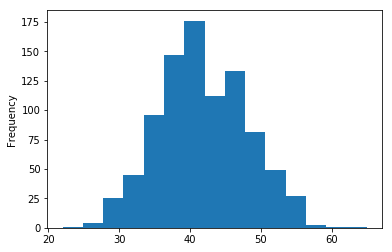

In [30]:
df_log['Age'].plot.hist(bins = 15)

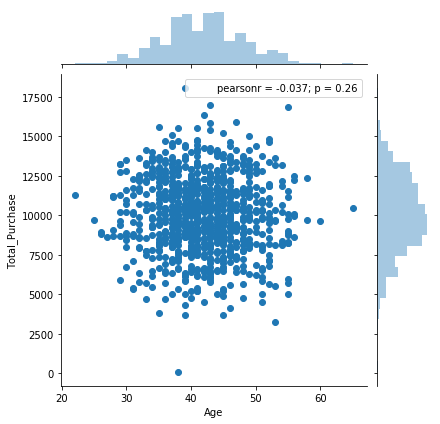

In [31]:
sns.jointplot(x = "Age", y = "Total_Purchase", data = df_log)

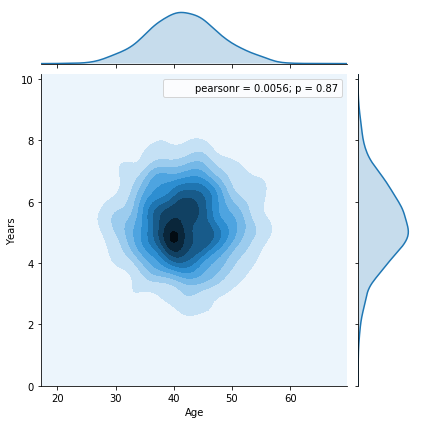

In [32]:
sns.jointplot(x = "Age", y = "Years", data = df_log, kind = "kde")

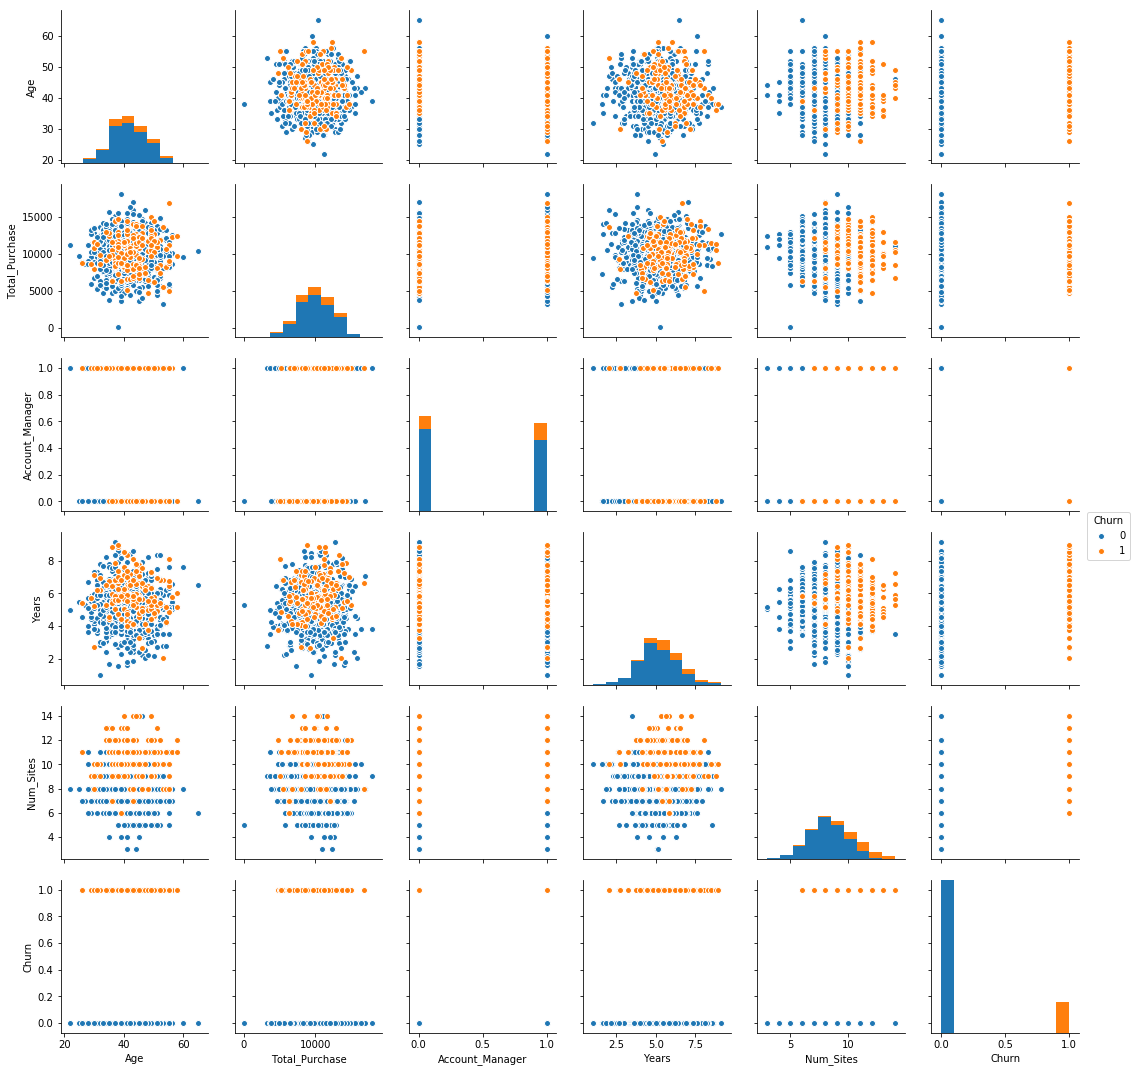

In [34]:
sns.pairplot(df_log, hue = 'Churn')

In [42]:
numeric_features = [t[0] for t in data.dtypes if t[1] == 'int' or t[1] == 'double']

In [43]:
corr = data.select(numeric_features).sample(False, 0.10).toPandas()

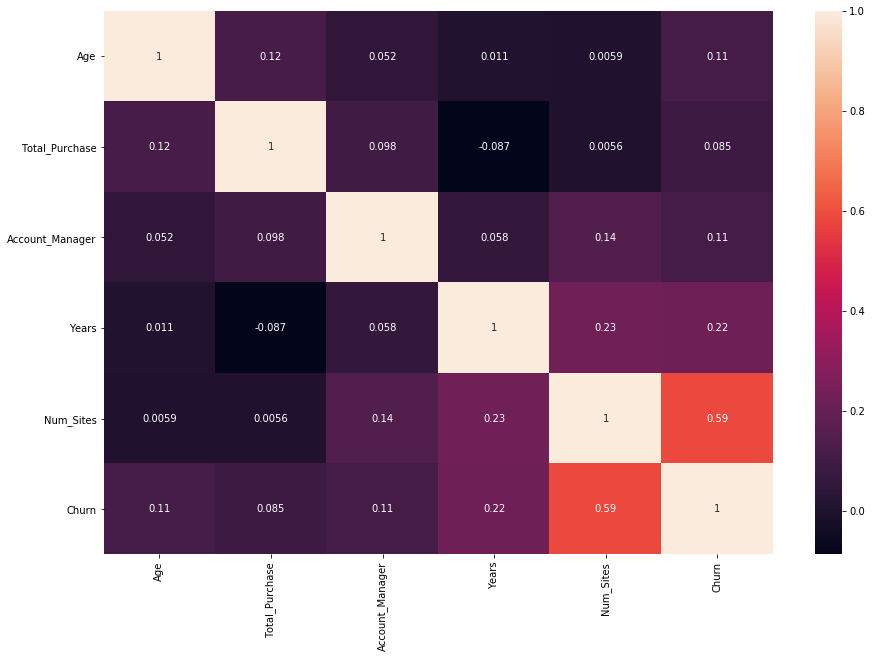

In [44]:
heatmap = sns.heatmap(data=corr.corr(), annot=True)
heatmap.figure.set_size_inches(15,10)

#### Scale Data

In [8]:
from pyspark.ml.feature import VectorAssembler

In [9]:
assembler=VectorAssembler(inputCols=['Age',
                                    'Total_Purchase',
                                     'Account_Manager',
                                     'Years',
                                     'Num_Sites'],
                         outputCol='features')

In [10]:
output=assembler.transform(data)

In [11]:
finalData=output.select('features','churn')

In [12]:
trainData,testData=finalData.randomSplit([0.7,0.3])

In [13]:
from pyspark.ml.classification import LogisticRegression

#### Train data model

In [14]:
lrResult=LogisticRegression(labelCol='churn')
finalResult=lrResult.fit(trainData)
trainSummary=finalResult.summary
trainSummary.predictions.describe().show()

+-------+-------------------+-------------------+
|summary|              churn|         prediction|
+-------+-------------------+-------------------+
|  count|                607|                607|
|   mean|0.16474464579901152|0.13673805601317957|
| stddev| 0.3712558639736437| 0.3438539614191953|
|    min|                0.0|                0.0|
|    max|                1.0|                1.0|
+-------+-------------------+-------------------+



#### Evaluate Model

In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictions=finalResult.evaluate(testData)
predictions.predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|churn|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[29.0,8688.17,1.0...|    1|[3.34481633697102...|[0.96593467941034...|       0.0|
|[29.0,9378.24,0.0...|    0|[5.29106988653698...|[0.99498886887284...|       0.0|
|[29.0,11274.46,1....|    0|[5.15765137574586...|[0.9942777321705,...|       0.0|
|[29.0,13240.01,1....|    0|[7.36453506103783...|[0.99936708104701...|       0.0|
|[30.0,6744.87,0.0...|    0|[4.07028004844036...|[0.98321397452952...|       0.0|
|[30.0,7960.64,1.0...|    1|[3.98226521867261...|[0.98169785333004...|       0.0|
|[30.0,10744.14,1....|    1|[2.13466295289871...|[0.89422686600457...|       0.0|
|[30.0,10960.52,1....|    0|[2.88005058676335...|[0.94685140937855...|       0.0|
|[30.0,13473.35,0....|    0|[3.03395676606196...|[0.95408481868832...|       0.0|
|[31.0,5304.6,0.

In [16]:
churn_eval=BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='churn')
auc=churn_eval.evaluate(predictions.predictions)
auc

0.7376543209876544

In [17]:
lrOnNewData=lrResult.fit(finalData)

#### Test model on another dataset

In [18]:
newCustomerData=spark.read.csv('new_customers.csv',inferSchema=True,header=True)

In [19]:
newCustomerData.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)



In [20]:
newSchema=assembler.transform(newCustomerData)

In [21]:
newSchema.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- features: vector (nullable = true)



In [22]:
newResults=lrOnNewData.transform(newSchema)

In [23]:
newResults.show()

+--------------+----+--------------+---------------+-----+---------+-------------------+--------------------+----------------+--------------------+--------------------+--------------------+----------+
|         Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|         Company|            features|       rawPrediction|         probability|prediction|
+--------------+----+--------------+---------------+-----+---------+-------------------+--------------------+----------------+--------------------+--------------------+--------------------+----------+
| Andrew Mccall|37.0|       9935.53|              1| 7.71|      8.0|2011-08-29 18:37:54|38612 Johnny Stra...|        King Ltd|[37.0,9935.53,1.0...|[2.22168705251440...|[0.90218018099704...|       0.0|
|Michele Wright|23.0|       7526.94|              1| 9.28|     15.0|2013-07-22 18:19:54|21083 Nicole Junc...|   Cannon-Benson|[23.0,7526.94,1.0...|[-6.2207530595020...|[0.00198380445828...|       

In [24]:
newResults.select('Company','prediction').show()

+----------------+----------+
|         Company|prediction|
+----------------+----------+
|        King Ltd|       0.0|
|   Cannon-Benson|       1.0|
|Barron-Robertson|       1.0|
|   Sexton-Golden|       1.0|
|        Wood LLC|       0.0|
|   Parks-Robbins|       1.0|
+----------------+----------+

